# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import torch
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR

from workspace_utils import active_session

import torch.nn.functional as F
import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import seaborn as sns
# print python & pytorch version
!python --version
print(f'PyTorch Version {torch.__version__}')

Python 3.6.3
PyTorch Version 0.4.0


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

# Configuration variables
img_size = 224 # Image size (see above)
reduction = 255 # Image reduction to smaller edge 
normalize_means = [0.485, 0.456, 0.406] # Normalized means of images
normalize_deviations = [0.229, 0.224, 0.225] # Normalize standard deviations of images
rotation = 45 # Rotation in degrees.
batch_size = 64 # Number of images used in a single pass
shuffle = True # Randomize image selection for a batch


# Verify GPU capabilities
print (torch.cuda.is_available())
print (torch.version.cuda)
# ------------- FIX BELOW --------------
# Environment controls
# Choose if run in CPU or GPU enabled hardware
#devices = ['cpu', 'cuda']
#current_device = devices[0]
# or use CUDA if available
# current_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# current_device
# torch.cuda.get_device_name(0)

True
8.0.61


In [3]:
# TODO: Define your transforms for the training, validation, and testing sets

# Create transforms pipelines to run/apply them in sequence on image data
# Next convert image data to sensors and normalize it to make backpropagation more stable
training_transforms = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
    transforms.RandomRotation(rotation),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(normalize_means, normalize_deviations)
])

validation_transforms = transforms.Compose([
    transforms.Resize(reduction),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(normalize_means, normalize_deviations)
])

testing_transforms = transforms.Compose([
    transforms.Resize(reduction),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(normalize_means, normalize_deviations)
])

data_transforms = {
    "training": training_transforms, 
    "validation": validation_transforms, 
    "testing": testing_transforms
}

# TODO: Load the datasets with ImageFolder
training_data = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_data = datasets.ImageFolder(valid_dir, transform=validation_transforms)
testing_data = datasets.ImageFolder(test_dir, transform=testing_transforms)

image_datasets = {
    "training": training_data, 
    "validation": validation_data, 
    "testing": testing_data
}

# TODO: Using the image datasets and the trainforms, define the dataloaders
training_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=shuffle)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
testing_loader = torch.utils.data.DataLoader(testing_data, batch_size=batch_size)

dataloaders = {
    "training": training_loader, 
    "validation": validation_loader, 
    "testing": testing_loader
}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
# view categories
for i, k in enumerate(cat_to_name.keys()):
    print(k, '\t:', cat_to_name[k])
    if i == 7:
        break
        
print("\nThere are {} image categories.".format(len(cat_to_name)))

21 	: fire lily
3 	: canterbury bells
45 	: bolero deep blue
1 	: pink primrose
34 	: mexican aster
27 	: prince of wales feathers
7 	: moon orchid
16 	: globe-flower

There are 102 image categories.


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [5]:
# TODO: Build and train your network

# Load a pre-trained network
# https://pytorch.org/docs/stable/torchvision/models.html
# VGG16
model_name = 'vgg16'
model = models.vgg16(pretrained=True)
model.name = model_name # add a new parameter to our model for the name

current_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
current_device
#Train on multiple GPUs if available, else train on cpu
if torch.cuda.device_count() > 1:
    print("Use all ", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model.to(current_device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:10<00:00, 51288796.36it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [7]:
# Back propagation is not needed. Falsify  requires_grad for faster calculations.
for param in model.parameters():
    param.requires_grad = False

In [8]:
# Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
class Classifier(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_layers, drop_out=0.2):
        super().__init__()
        
        # Add input layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add hidden layers
        h_layers = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h_input, h_output) for h_input, h_output in h_layers])
        
        # Add output layer
        self.output = nn.Linear(hidden_layers[-1], output_size)

        # Dropout module with drop_out drop probability
        self.dropout = nn.Dropout(p=drop_out)

    def forward(self, x):
        # Flaten tensor input
        x = x.view(x.shape[0], -1)

        # Add dropout to hidden layers
        for layer in self.hidden_layers:
            x = self.dropout(F.relu(layer(x)))        

        # Output so no dropout here
        x = F.log_softmax(self.output(x), dim=1)

        return x


In [9]:
# Replace the classifier part of the pre-trained model with fully-connected layers

input_size = 25088
output_size = 102
hidden_layers = [4096, 1024]
drop_out = 0.2

model.classifier = Classifier(input_size, output_size, hidden_layers, drop_out)


In [10]:
# Define the loss function
criterion = nn.NLLLoss()

# Define weights optimizer (backpropagation with gradient descent)
# Only train the classifier parameters, feature parameters are frozen
# Set the learning rate as lr=0.001
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

# Move the network and data to GPU or CPU
model.to(current_device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [11]:
# A function used for validation and testing
def testClassifier(model, criterion, testloader, current_device):
    
    # Move the network and data to current hardware config (GPU or CPU)
    model.to(current_device)
        
    test_loss = 0
    accuracy = 0
        
    # Looping through images, get a batch size of images on each loop
    for inputs, labels in testloader:

        # Move input and label tensors to the default device
        inputs, labels = inputs.to(current_device), labels.to(current_device)

        # Forward pass, then backward pass, then update weights
        log_ps = model.forward(inputs)
        batch_loss = criterion(log_ps, labels)
        test_loss += batch_loss.item()

        # Convert to softmax distribution
        ps = torch.exp(log_ps)
        
        # Compare highest prob predicted class with labels
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        
        # Calculate accuracy
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    
    return test_loss, accuracy



In [15]:
# A function used for training (and tests with different model hyperparameters)
def trainClassifier(model, num_of_epochs, criterion, optimizer, training_loader, validation_loader, current_device):
    
    # Move the network and data to current hardware config (GPU or CPU)
    model.to(current_device)
    
    steps = 0

    running_loss = 0
    #define adaptive learning rate by step size count
#     scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
    # Looping through epochs, each epoch is a full pass through the network
    for epoch in range(num_of_epochs):
        
#         scheduler.step()
        # Switch to the train mode
        model.train()

        # Looping through images, get a batch size of images on each loop
        for inputs, labels in training_loader:

            steps += 1

            # Move input and label tensors to the default device
            inputs, labels = inputs.to(current_device), labels.to(current_device)

            # Clear the gradients, so they do not accumulate
            optimizer.zero_grad()

            # Forward pass, then backward pass, then update weights
            log_ps = model(inputs)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
#             print(loss.item())
#             print(running_loss)
        # Track the loss and accuracy on the validation set to determine the best hyperparameters
            
        # Put in evaluation mode
        model.eval()

        # Turn off gradients for validation, save memory and computations
        with torch.no_grad():
            # Validate model
            test_loss, accuracy = testClassifier(model, criterion, validation_loader, current_device)
                       
        train_loss = running_loss #(e)
        valid_loss = test_loss/len(validation_loader)
        valid_accuracy = accuracy/len(validation_loader)

        print(f"Epoch {epoch+1}/{num_of_epochs}:  "
              f"Train loss: {train_loss:.3f} | "
              f"Test loss: {valid_loss:.3f} | "
              f"Test accuracy: {valid_accuracy:.3f}")

        running_loss = 0

        # Switch back to the train mode
        model.train()
                
    # Return last metrics
    return train_loss, valid_loss, valid_accuracy

In [16]:
def saveCheckpoint(model):
    
    # Mapping of classes to indices
    model.class_to_idx = training_data.class_to_idx
    
    # Create model metadata dictionary
    checkpoint = {
        'name': model.name,
        'class_to_idx': model.class_to_idx,
        'classifier': model.classifier,
        'model_state_dict': model.state_dict()
    }

    # Save to a file
    timestr = time.strftime("%Y%m%d_%H%M%S")
    file_name = 'model_' + model.name + timestr + '.pth'
    torch.save(checkpoint, file_name)
    
    return file_name

In [17]:
# Train the classifier layers using backpropagation using the pre-trained network to get the features

# Train attempt #1
# Parameters
drop_out = 0.2
# Optimizer type and learning rate
# learning_rate = 0.05
# See https://stackoverflow.com/questions/42966393/is-it-good-learning-rate-for-adam-method
learning_rate = 0.001
# Define weights optimizer (backpropagation with gradient descent)
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
# Num of epochs
num_of_epochs = 40

# To ensure the GPU workspace session is not terminated
print('\nTrain #1 (results per epoch) ------')
with active_session():
    # Train and validate the neural network classifier
    train_loss, valid_loss, valid_accuracy = trainClassifier(
        model, 
        num_of_epochs, 
        criterion, 
        optimizer, 
        training_loader, 
        validation_loader, 
        current_device
    )

# Display final summary
print("\nFinal result\n",
      f"Train loss: {train_loss:.3f}   \n",
      f"Test loss: {valid_loss:.3f}   \n",
      f"Test accuracy: {valid_accuracy:.3f}")

# Save checkpoint
#model_name = 'vgg16'
filename = saveCheckpoint(model)




Train #1 (results per epoch) ------
Epoch 1/40:  Train loss: 206.416 | Test loss: 1.201 | Test accuracy: 0.662
Epoch 2/40:  Train loss: 169.753 | Test loss: 0.945 | Test accuracy: 0.743
Epoch 3/40:  Train loss: 151.452 | Test loss: 0.884 | Test accuracy: 0.748
Epoch 4/40:  Train loss: 141.147 | Test loss: 0.797 | Test accuracy: 0.785
Epoch 5/40:  Train loss: 132.158 | Test loss: 0.773 | Test accuracy: 0.797
Epoch 6/40:  Train loss: 129.226 | Test loss: 0.704 | Test accuracy: 0.811
Epoch 7/40:  Train loss: 121.368 | Test loss: 0.738 | Test accuracy: 0.818
Epoch 8/40:  Train loss: 126.941 | Test loss: 0.703 | Test accuracy: 0.837
Epoch 9/40:  Train loss: 120.656 | Test loss: 0.623 | Test accuracy: 0.838
Epoch 10/40:  Train loss: 120.315 | Test loss: 0.686 | Test accuracy: 0.835
Epoch 11/40:  Train loss: 115.227 | Test loss: 0.651 | Test accuracy: 0.841
Epoch 12/40:  Train loss: 113.075 | Test loss: 0.641 | Test accuracy: 0.851
Epoch 13/40:  Train loss: 111.883 | Test loss: 0.697 | Test 

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Classifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [18]:
# TODO: Do validation on the test set
model.eval()
            
# Turn off gradients for testing (this saves memory, computation cycles)
with torch.no_grad():

    # Testing model
    test_loss, accuracy = testClassifier(model, criterion, testing_loader, current_device)

print(f"Test accuracy: {accuracy/len(testing_loader):.3f}")

Test accuracy: 0.867


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [19]:
# view model and state details
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())


Our model: 

 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [20]:
# TODO: Save the checkpoint  
# see function saveCheckpoint() above
# model is already saved with variable 'filename'
print ('Saved model in file ' + filename)

Saved model in file model_vgg1620210319_153105.pth


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [21]:
# TODO: Write a function that loads a checkpoint and rebuilds the model


def recreateModel(filepath):
    
    # Load model metadata
    # Loading weights for CPU model which were trained on GPU
    # https://discuss.pytorch.org/t/loading-weights-for-cpu-model-while-trained-on-gpu/1032
    checkpoint = torch.load(filepath, map_location=lambda storage, loc: storage)
    
    # Recreate the pretrained base model
    #model = models.vgg16(pretrained=True)
    model = getattr(models, checkpoint['name'])(pretrained=True)
    
    # Replace the classifier part of the model
    model.classifier = checkpoint['classifier']
    
    # Rebuild saved state dict
    model.load_state_dict(checkpoint['model_state_dict'])

    # Load class_to_idx
    model.class_to_idx = checkpoint['class_to_idx']

    return model


# Classifier class definition must be loaded (if not done) 
# in order to rebuild the model (see above)

model_from_file = recreateModel(filename)
model_from_file


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

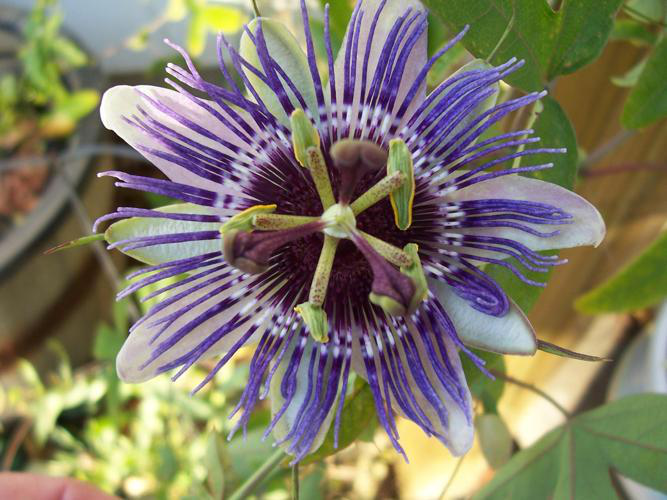

In [22]:
# Display original image
image_path = 'flowers/test/77/image_00050.jpg'
img = Image.open(image_path)
img

In [23]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
      # Find the shorter side and resize it to 256 keeping aspect ration
    # if the width > height
    if image.width > image.height:        
        # Constrain the height to be 256
        image.thumbnail((10000000, 256))
    else:
        # Constrain the width to be 256
        image.thumbnail((256, 10000000))
    
    # Center crop the image
    crop_size = 224
    left_margin = (image.width - crop_size) / 2
    bottom_margin = (image.height - crop_size) / 2
    right_margin = left_margin + crop_size
    top_margin = bottom_margin + crop_size  
    image = image.crop((left_margin, bottom_margin, right_margin, top_margin))
    
    # Convert values to range of 0 to 1 instead of 0-255
    image = np.array(image)
    image = image / 255
    
    # Standardize values
    means = np.array([0.485, 0.456, 0.406]) # provided mean
    stds = np.array([0.229, 0.224, 0.225]) #provided std
    image = (image - means) / stds
    
    # Move color channels to first dimension as expected by PyTorch
    image = image.transpose(2, 0, 1)
    
    return image


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [24]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
#     image = image.numpy().transpose((1, 2, 0))
 # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

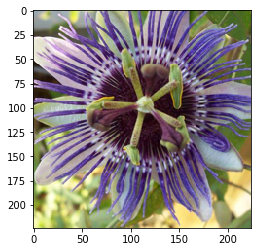

In [25]:
# Test image processing & show the transformed image
img_ready = process_image(img)
imshow(img_ready);

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [26]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
     # Move model into evaluation mode and to CPU
    model.eval()
    model.cpu()
   
    # Open image
    image = Image.open(image_path)
    
    # Process image
    image = process_image(image) 
    
    # Change numpy array type to a PyTorch tensor
    image = torch.from_numpy(image).type(torch.FloatTensor) 
    
    # Format tensor for input into model
    # (add batch of size 1 to image)
    # https://pytorch.org/docs/stable/torch.html#torch.unsqueeze
    image = image.unsqueeze(0)
    
    # Predict top K probabilities
    # Reverse the log conversion
    probs = torch.exp(model.forward(image))
    top_probs, top_labs = probs.topk(topk)
    #print(top_probs)
    #print(top_labs)
    
    # Convert from Tesors to Numpy arrays
    top_probs = top_probs.detach().numpy().tolist()[0]
    idx_to_class = {model.class_to_idx[k]: k for k in model.class_to_idx}
    
    # Map tensor indexes to classes
    labs = []
    for label in top_labs.numpy()[0]:
        labs.append(idx_to_class[label])

    return top_probs, labs

In [27]:
# test code: Predict class of an image
probs, classes = predict(image_path, model_from_file, topk=5)
print(image_path)
print(probs)
print(classes)

flowers/test/77/image_00050.jpg
[1.0, 2.0869342430344656e-35, 6.445812941240696e-36, 6.303320841908994e-36, 1.600699334583314e-36]
['77', '18', '40', '81', '79']


In [28]:
def categoryToName(categories, mapper='cat_to_name.json'):
    
    # Load json file
    with open(mapper, 'r') as f:
        cat_to_name = json.load(f)
        #print(cat_to_name)
    
        names = []

        # Find flower names corresponding to predicted categories
        for category in categories:
            names.append(cat_to_name[str(category)])

    return names

In [29]:
# Make prediction more human-friendly by translating
# class identifiers into names
names = categoryToName(classes)
print(probs)
print(classes)
print(names)

[1.0, 2.0869342430344656e-35, 6.445812941240696e-36, 6.303320841908994e-36, 1.600699334583314e-36]
['77', '18', '40', '81', '79']
['passion flower', 'peruvian lily', 'lenten rose', 'frangipani', 'toad lily']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [ ]:
# TODO: Display an image along with the top 5 classes

In [30]:
# Choose a random image file path from a folder 
# structure below specified parent path
def select_random_image(path):
    
    # Select random file
    random_folder = random.choice(os.listdir(path))
    random_file = random.choice(
    os.listdir(os.path.join(path, random_folder)))

    # Create image path
    image_path = os.path.join(path, random_folder, random_file)

    return image_path

In [32]:
# Select random image and predict its class
# Visualize the result
def display_predictions(path, model, topk=5, flower_names=None):

    # Return random path to an image
    image_path = select_random_image(path)
    print(image_path)
    
    # Return folder number which equals to 
    # a class identifier
    folder_number = image_path.split('/')[2]
    #print(folder_number)
    
    # Read the flower name based on the folder
    # number (flower class id) and external dictionary mapping 
    title = flower_names[folder_number]
    #print(title)
    
    # Predict image class
    probs, classes = predict(image_path, model, topk)
    #print(probs)
    #print(classes)
    
    # Convert class id into its name
    names = categoryToName(classes)
    print('full name:', names)
    print('category :', classes)
    
    # Open an image
    image = Image.open(image_path)
    
    # Make the image compliant with PyTorch
    image = process_image(image)
    
    # Set up a plot
    plt.figure(figsize = (6, 10))
    ax = plt.subplot(2, 1, 1)

    # Plot the flower
    imshow(image, ax, title=title);

    # Visualize prediction result
    plt.subplot(2, 1, 2)
    sns.barplot(x=probs, y=names, color=sns.color_palette()[0]);
    plt.show()

    return

flowers/test/63/image_05878.jpg
full name: ['black-eyed susan', 'osteospermum', 'oxeye daisy', 'barbeton daisy', 'english marigold']
category : ['63', '66', '49', '41', '5']


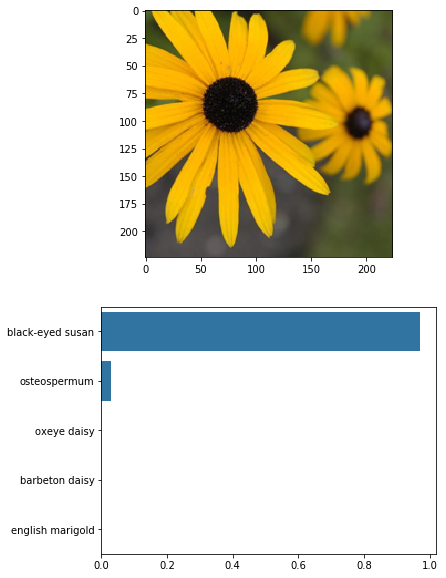

flowers/test/90/image_04469.jpg
full name: ['canna lily', 'azalea', 'sword lily', 'bougainvillea', 'fire lily']
category : ['90', '72', '43', '95', '21']


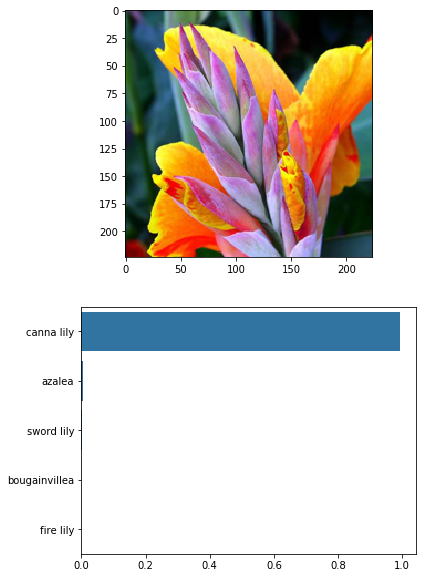

flowers/test/5/image_05169.jpg
full name: ['english marigold', 'barbeton daisy', 'primula', 'blanket flower', 'mexican aster']
category : ['5', '41', '53', '100', '34']


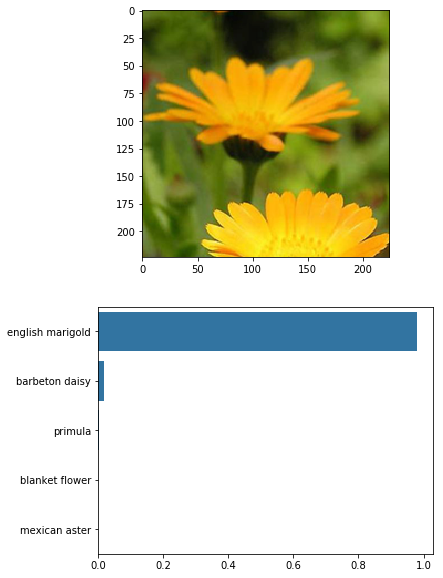

flowers/test/75/image_02119.jpg
full name: ['thorn apple', 'giant white arum lily', 'morning glory', 'camellia', 'sword lily']
category : ['75', '20', '76', '96', '43']


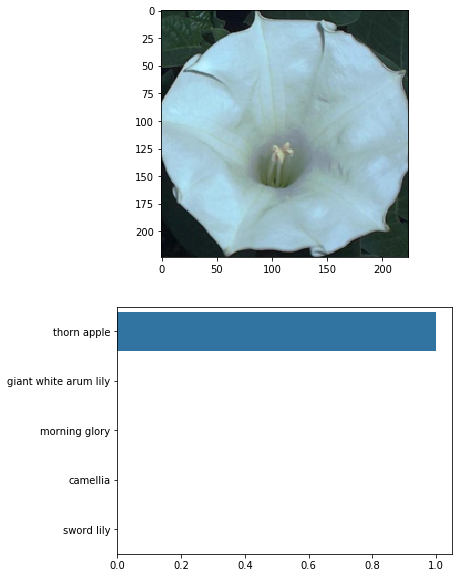

flowers/test/30/image_03512.jpg
full name: ['primula', 'petunia', 'sweet william', 'garden phlox', 'clematis']
category : ['53', '51', '30', '32', '82']


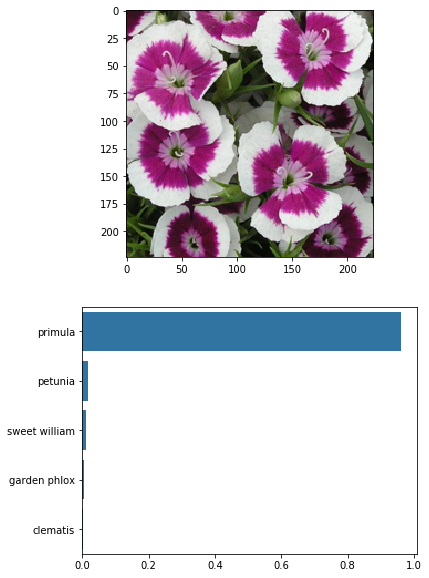

In [33]:
# TODO: Display an image along with the top 5 classes

# Perform prediction on a number of images
number_of_predictions = 5

for i in range(number_of_predictions):
    display_predictions('flowers/test', model_from_file, flower_names=cat_to_name)